## TinySOL instrument classification task using Essentia Music Extractor.

In [5]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

TinySOL is a dataset of 2913 samples, each containing a single musical note from one of 14 different instruments.
TinySOL can be used for education and research purposes. In particular, it can be employed as a dataset for training and/or evaluating music information retrieval (MIR) systems, for tasks such as instrument recognition or fundamental frequency estimation.

In [7]:
tinysol = mirdata.initialize("tinysol")

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
tinysol.download()  # download the dataset

In [9]:
tinysol.validate()  # validate that all the expected files are there

100%|██████████| 2913/2913 [00:04<00:00, 606.90it/s]


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

In [10]:
tinysol_ids = tinysol.track_ids  # Load Mridangam IDs
tinysol_data = tinysol.load_tracks()  # Load Mridangam data

tinysol_data[tinysol_ids[0]]  # Visualize a single track

Track(
  audio_path="/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav",
  track_id="BTb-ord-F#1-pp-N-N",
  audio: The track's audio

        Returns,
  dynamics: ,
  dynamics_id: ,
  family: ,
  instance_id: ,
  instrument_abbr: ,
  instrument_full: ,
  is_resampled: ,
  pitch: ,
  pitch_id: ,
  split: ,
  string_id: ,
  technique_abbr: ,
  technique_full: ,
)

In [11]:
# Get complete list of different instruments labels
tinysol_instruments = []
for i in tinysol_ids:
    tinysol_instruments.append(tinysol_data[i].instrument_full)
tinysol_instruments_unique = np.unique(tinysol_instruments)
# converting the list into a set of strings (unordered, with no repetitions -unique data-)
print(tinysol_instruments_unique)

['Accordion' 'Alto Saxophone' 'Bass Tuba' 'Bassoon' 'Cello'
 'Clarinet in Bb' 'Contrabass' 'Flute' 'French Horn' 'Oboe' 'Trombone'
 'Trumpet in C' 'Viola' 'Violin']


In [12]:
# You can create a dictionary using tonics as keys and audio paths as values
instruments_dict = {item: [] for item in tinysol_instruments}
# will be used when retrieving features from audio files and writing into .csv file
file_paths_list = [] 
instruments_fullname_list = []
for i in tinysol_ids:
    instruments_dict[tinysol_data[i].instrument_full].append(tinysol_data[i].audio_path)
    file_paths_list.append(tinysol_data[i].audio_path)
    instruments_fullname_list.append(tinysol_data[i].instrument_full)

for key in instruments_dict.keys():
  print(f'Audio paths of files labelled with instrument {key}')
  print(instruments_dict.get(key))

Audio paths of files labelled with instrument Bass Tuba
['/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100u.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16u.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-B1-pp-N-N.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-C2-pp-N-T13d.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-C#2-pp-N-N.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-D2-pp-N-T18u.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-D#2-pp-N-T11u.wav', '/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-E2-pp-N-T25

Plot waveforms of random samples of each instrument type...


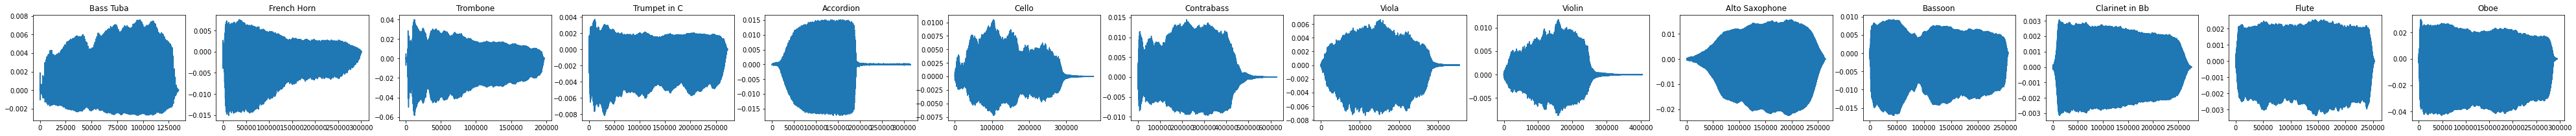

In [13]:
# Raw-data preprocess analysis parameters
_, fs = tinysol_data[tinysol_ids[0]].audio

num_instruments = len(instruments_dict.keys())
print("Plot waveforms of random samples of each instrument type...")
plt.figure(1, figsize=(5 * num_instruments, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, tonic in enumerate(instruments_dict.keys()):
    sample_file = instruments_dict[tonic][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_instruments,(i+1))
    plt.plot(x)
    plt.title(tonic)

## Feature extraction 

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [14]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(tinysol_data[tinysol_ids[0]].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [15]:
# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = 'sample_data/data.csv'
file_count = 0
iteration_n = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['instrument']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in file_paths_list:
        # print(f'Processing file {filename}')
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        label = instruments_fullname_list[iteration_n]
        # print(f'Label for this file: {label}')
        line2write = str(selected_features)[1:-1] + ',' + label + '\n'
        writer.write(line2write)
        iteration_n += 1
print("A total of ", file_count, "files processed")

20 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-C#3-pp-N-N.wav
40 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-A1-mf-N-T33u.wav
60 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-F3-mf-N-N.wav
80 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-C#2-ff-N-N.wav
100 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-A3-ff-N-N.wav
120 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Horn/ordinario/Hn-ord-A2-pp-N-R100u.wav
140 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Horn/ordinario/Hn-ord-F4-pp-N-N.wav
160 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Horn/ordinario/Hn-ord-D2-mf-N-N.wav
180 files processed, current file:  /root/mir_datasets/tinysol/audio/Brass/Ho

In [16]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,instrument
0,0.972552,8.409534,1.144080,0.446386,0.060015,9.493382,19.056255,1.141775,1.308129,3.061680,...,1430.113892,6.908469,1.688109,2058337.500,1827199.000,0.307684,0.098845,0.007163,0.005299,Bass Tuba
1,0.987932,7.737574,1.062609,0.431098,0.055529,9.831431,15.997477,1.093505,1.228107,2.576996,...,794.864319,6.603456,1.446844,2004203.750,1424922.625,0.565711,0.606314,0.008125,0.007040,Bass Tuba
2,0.977264,7.017447,1.557238,0.450940,0.064779,3.441059,15.226211,0.479126,1.119596,3.132955,...,1495.037476,10.009058,2.345824,1368292.875,1768582.500,0.355884,0.159810,0.011065,0.011138,Bass Tuba
3,0.978420,8.197027,1.043337,0.407936,0.060264,12.807643,14.228601,1.277687,1.195519,2.662251,...,1696.913696,6.570394,1.548001,2211143.250,1841596.875,0.414092,0.317596,0.018260,0.014639,Bass Tuba
4,0.981588,7.884830,1.527937,0.455036,0.067737,2.158736,10.539771,0.207712,0.961212,3.402941,...,1755.925659,10.873639,2.521345,1243969.125,1803341.250,0.864981,0.496939,0.013012,0.012325,Bass Tuba


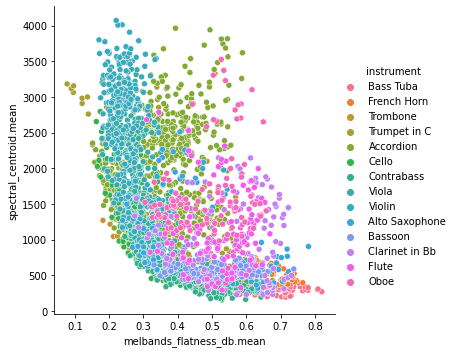

In [17]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "instrument", data = data);

### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
# Scale everything between 0 and 1 (data normalization)
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [ ]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
# Balance data, in a classification task, tends to have the same amount of training examples for each label
# https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
data_modif.instrument.value_counts()

Accordion         689
Contrabass        309
Viola             309
Cello             291
Violin            284
French Horn       134
Bassoon           126
Clarinet in Bb    126
Flute             118
Trombone          117
Bass Tuba         108
Oboe              107
Alto Saxophone     99
Trumpet in C       96
Name: instrument, dtype: int64

In [ ]:
'''
It seems like sampling around 130 examples from each instruments
class is a good balance (you can see that from the summary above..)
'''
# We use pandas.DataFrame.sample()

min_number = data_modif.instrument.value_counts()['Bassoon']
print(f'All data will be randomly re-sampled with {min_number} values. The classes that had fewer examples than {min_number} will be upsampled.')

accordion_data = data_modif[data_modif.instrument == 'Accordion'].sample(n = min_number, random_state = 42)
contrabass_data = data_modif[data_modif.instrument == 'Contrabass'].sample(n = min_number)
viola_data = data_modif[data_modif.instrument == 'Viola'].sample(n = min_number)
cello_data = data_modif[data_modif.instrument == 'Cello'].sample(n = min_number)
violin_data = data_modif[data_modif.instrument == 'Violin'].sample(n = min_number)
frenchHorn_data = data_modif[data_modif.instrument == 'French Horn'].sample(n = min_number)
bassoon_data = data_modif[data_modif.instrument == 'Bassoon'].sample(n = min_number)
clarinetInBb_data = data_modif[data_modif.instrument == 'Clarinet in Bb'].sample(n = min_number)
flute_data = data_modif[data_modif.instrument == 'Flute'].sample(n = min_number, replace=True)
trombone_data = data_modif[data_modif.instrument == 'Trombone'].sample(n = min_number, replace=True)
bassTuba_data = data_modif[data_modif.instrument == 'Bass Tuba'].sample(n = min_number, replace=True)
oboe_data = data_modif[data_modif.instrument == 'Oboe'].sample(n = min_number, replace=True)
altoSaxophone_data = data_modif[data_modif.instrument == 'Alto Saxophone'].sample(n = min_number, replace=True)
trumpetInC_data = data_modif[data_modif.instrument == 'Trumpet in C'].sample(n = min_number, replace=True)


#Merging after downsampling
data_modif = pd.concat([accordion_data, contrabass_data, viola_data, cello_data, violin_data, frenchHorn_data, bassoon_data, clarinetInBb_data, flute_data, trombone_data, bassTuba_data, oboe_data, altoSaxophone_data, trumpetInC_data])
#Checking the balance again
print(data_modif.instrument.value_counts())

All data will be randomly re-sampled with 126 values. The classes that had fewer examples than 126 will be upsampled.
Accordion         126
Contrabass        126
Viola             126
Cello             126
Violin            126
French Horn       126
Bassoon           126
Clarinet in Bb    126
Flute             126
Trombone          126
Bass Tuba         126
Oboe              126
Alto Saxophone    126
Trumpet in C      126
Name: instrument, dtype: int64


## Supervised learning approach (Support Vector Machines)

In [ ]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.instrument = pd.Categorical(data_modif.instrument)  # convert to categorical data
y = np.array(data_modif.instrument.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [9.36577225e-01 3.33895230e-01 4.88351992e-01 9.80156099e-02
 4.70458591e-02 3.65354162e-04 8.30162653e-04 2.13090505e-01
 2.88527555e-02 4.65284334e-01 2.65558364e-01 8.94315497e-01
 1.06548662e-01 3.24543418e-01 3.47600773e-02 8.47914299e-02
 1.03639643e-01 1.82511285e-01 3.44666230e-03 5.17415195e-03
 1.70841675e-01 5.48096610e-02 6.65444652e-01 3.29866764e-01
 2.18485414e-01 1.72101620e-01 4.32996321e-01 1.58672363e-01
 3.64004656e-01 5.99767245e-01 4.43884958e-01 5.21291579e-02
 3.49155630e-01 6.02159462e-01 1.90033620e-01 4.82986403e-02
 3.16574117e-02 8.62388026e-02 5.66179512e-01 1.82950383e-01
 2.49404610e-01 1.93597184e-01 6.64458770e-01 6.54923550e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 4.24270885e-01 8.81689352e-01 2.89172989e-01 4.75977243e-01
 5.73462244e-01 6.38912206e-01 9.29214630e-01 7.80214927e-02
 7.22208705e-02 7.77866972e-02 5.90979311e-03 5.36457605e-03
 3.58246883e-03 4.06906933e-03 1.47947182e-01 1.922232

In [ ]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (1181, 84) , Size of train output vector:  (1181,)
Size of test features matrix:  (583, 84) , Size of test output vector:  (583,)


In [ ]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.8593481989708405


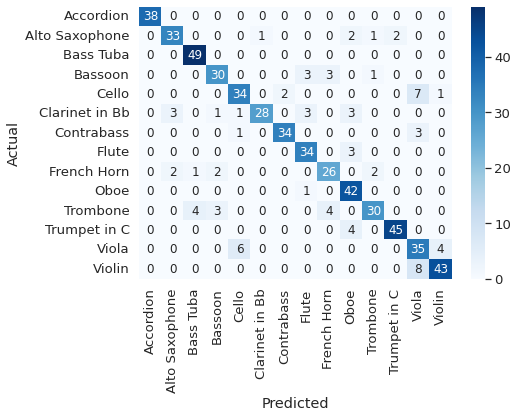

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.instrument)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (1411, 14)
One-hot encoded y_test shape =  (353, 14)


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 42))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 21))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    '''
    As a test, without hidden layers (with no hidden layer 1 and 2, number of epochs == 250),
    the accuracy of the model goes form 0.95 to 0.91.
    So the Architecture does not matter much in this case.
    '''

    # Output layer
    # 14 instruments classes as output
    model.add(layers.Dense(name='Output_layer', units = 14))
    model.add(layers.Activation('sigmoid'))
    
    return model

print(f'Numbner of features; {X_train_val.shape[1]}')
model = compose_model(X_train_val.shape[1])

Numbner of features; 84


In [ ]:
model.summary()  # Plot summary of the model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 42)                3570      
                                                                 
 batch_normalization_10 (Bat  (None, 42)               168       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 42)                0         
                                                                 
 dropout_10 (Dropout)        (None, 42)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 21)               

In [ ]:
'''
I noticed that not every times that i .fit() the same exact model, I get the same
accuracy value (but anyway there is no big difference in the accuracy value; the
difference is around 0.01). This is probably due to random weights initialization.
'''

model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0161481611430645
Test accuracy: 0.9745042324066162


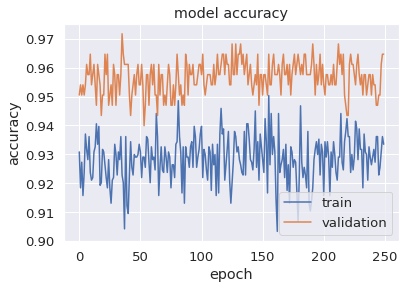

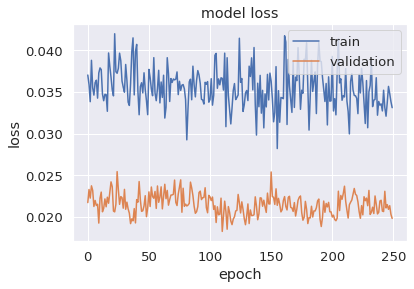

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
'''
Also reducing the number of epochs does not seem to impact the accuracy at all.
Of course training is faster with fewer number of epochs.
'''

summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 100, validation_split=0.2, verbose=0)

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01992940343916416
Test accuracy: 0.9575070738792419


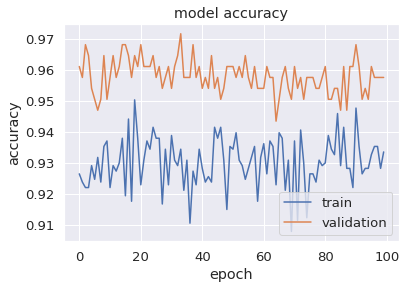

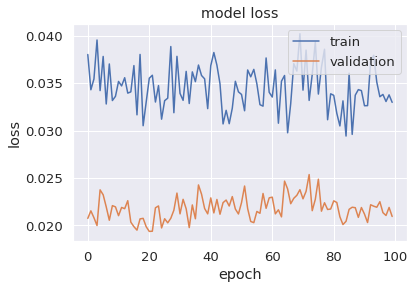

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()